In [1]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 

from data_gathering import get_traffic, get_active_cameras_by_segment, get_all_cameras

# Graph parameters
plt.rcParams['figure.figsize'] = [15, 5]
bimensual_locator = mdates.WeekdayLocator(byweekday=mdates.MO, interval=2) #monday every 2 weeks
daily_locator = mdates.DayLocator()

## Cameras per segments
Get all the segments for which the two versions operate simultaneously

In [3]:
cameras = get_all_cameras()
cameras_per_segments = cameras.groupby('segment_id')['hardware_version'].nunique()
cameras_per_segments.sort_values(ascending=False)[0:10]

segment_id
9000002105    2
9000001038    2
9000002156    2
9000002477    2
9000004732    1
9000004736    1
9000004737    1
9000004739    1
9000004741    1
9000004743    1
Name: hardware_version, dtype: int64

## Parameters

In [4]:
segment_id = 9000002156 #burel = 9000002156
yesterday = (datetime.now() - timedelta(2))
last_week_day= (datetime.now() - timedelta(9))

cameras = get_active_cameras_by_segment(segment_id)
start_period = max([cam['time_added'] for cam in cameras.values()])
end_period = yesterday.strftime('%Y-%m-%d %H:%M:%SZ')

## Get Telraam data 

In [5]:
telraam_data_raw = pd.DataFrame()
for version, cam_details in cameras.items():
    telraam_tmp_raw = get_traffic(cam_details['id'], start_period, end_period, level='instances')
    telraam_tmp_raw['version'] = version
    telraam_data_raw = pd.concat([telraam_data_raw, telraam_tmp_raw], ignore_index=True)

#burel.to_csv(f"data/burel_{yesterday.strftime('%Y%m%d')}.csv", index=False)

## Preprocessing

In [6]:
telraam_data = telraam_data_raw.copy()

### Transportation modes

In [7]:
transportation_modes = ['car','bike','pedestrian','heavy','vehicules']
direction_modes = [mode + '_lft' for mode in transportation_modes] + [mode + '_rgt' for mode in transportation_modes]

telraam_data['vehicules'] = telraam_data['car'] + telraam_data['heavy']
telraam_data['vehicules_lft'] = telraam_data['car_lft'] + telraam_data['heavy_lft']
telraam_data['vehicules_rgt'] = telraam_data['car_rgt'] + telraam_data['heavy_rgt']

### Dates

In [8]:
#burel = pd.read_csv('data/burel_20231018.csv')

telraam_data['date'] = pd.to_datetime(telraam_data_raw['date']).dt.tz_localize(None)
telraam_data['day'] = telraam_data['date'].dt.date
telraam_data['hour'] = telraam_data['date'].dt.hour

dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
telraam_data['day_of_week'] = telraam_data['date'].dt.strftime('%A')
telraam_data['day_of_week'] = pd.Categorical(telraam_data['day_of_week'], categories=dow_order)

### Versions

In [9]:
version_order = ['v1','v2']
telraam_data['version'] = pd.Categorical(telraam_data['version'], categories=version_order)

### Uptime

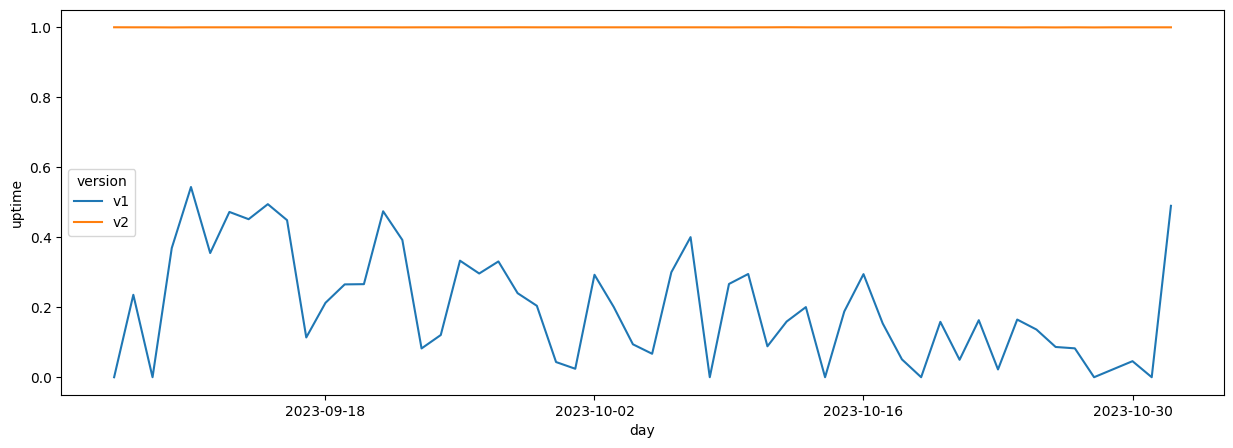

In [10]:
id_var = ['day','version']
median_uptime = telraam_data.groupby(id_var, observed=False)['uptime'].median().reset_index()
sns.lineplot(median_uptime, x="day", y="uptime", hue="version", errorbar=None)
ax = plt.gca()
ax.xaxis.set_major_locator(bimensual_locator)

In [11]:
telraam_data_filtered = telraam_data.query('uptime > 0.5')

## Analysis

Ideas :
- daily aggregation and comparison 
    - global (or just cars + heavy)
    - by transportation mode
    - by directions
- by moment of time :
    - day of week
    - hour
- uptime differences ?
- v85 differences ?
- directions

### Evolution - by Transportation mode (last week)

In [14]:
id_var = ['version','date']
last_week = telraam_data[telraam_data['date']> np.datetime64(last_week_day)].copy()
evolution = last_week.groupby(id_var, observed=False)[transportation_modes].sum().reset_index()
evolution = pd.melt(evolution, id_vars=id_var, var_name="mode")

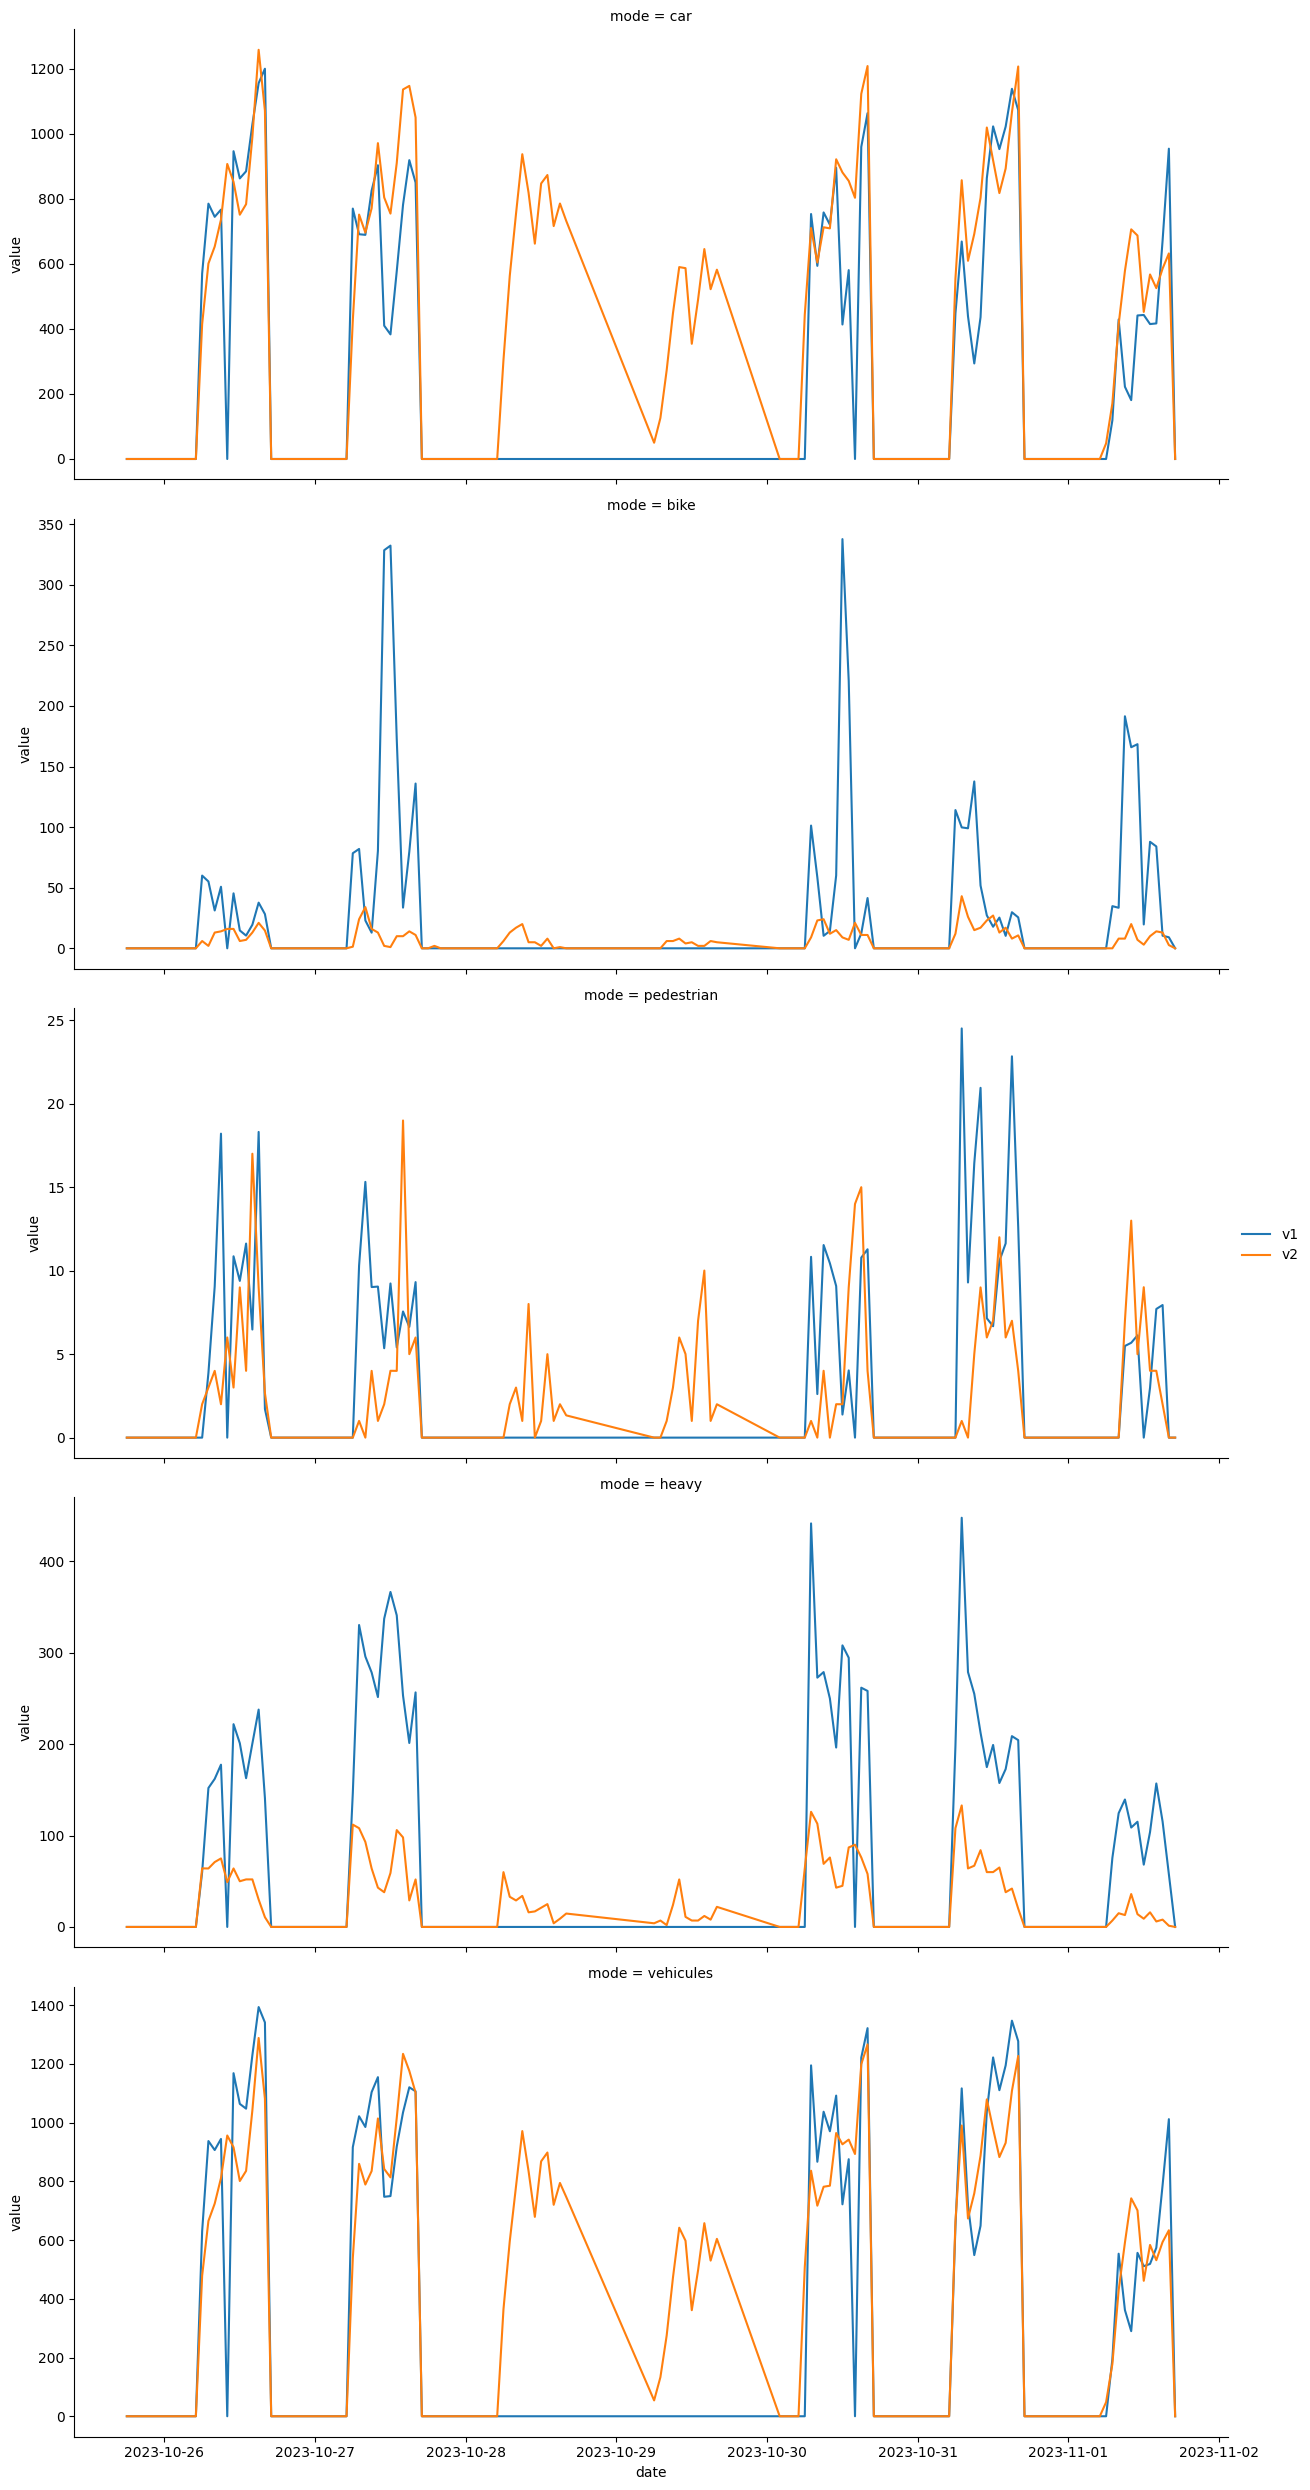

In [15]:
g = sns.FacetGrid(evolution, col="mode", sharey=False, col_wrap=1, height=5, aspect=2.5)
g.map_dataframe(sns.lineplot, x='date', y='value', hue='version', errorbar=None)
g.add_legend()
ax = plt.gca()
ax.xaxis.set_major_locator(daily_locator)

### Daily - by Transportation mode

In [21]:
id_var = ['day','version']
evolution = telraam_data_filtered.groupby(id_var, observed=False)[transportation_modes].sum().reset_index()
evolution = pd.melt(evolution, id_vars=id_var, var_name="mode")
evolution['day'] = pd.to_datetime(evolution['day'], format='%Y-%m-%d')

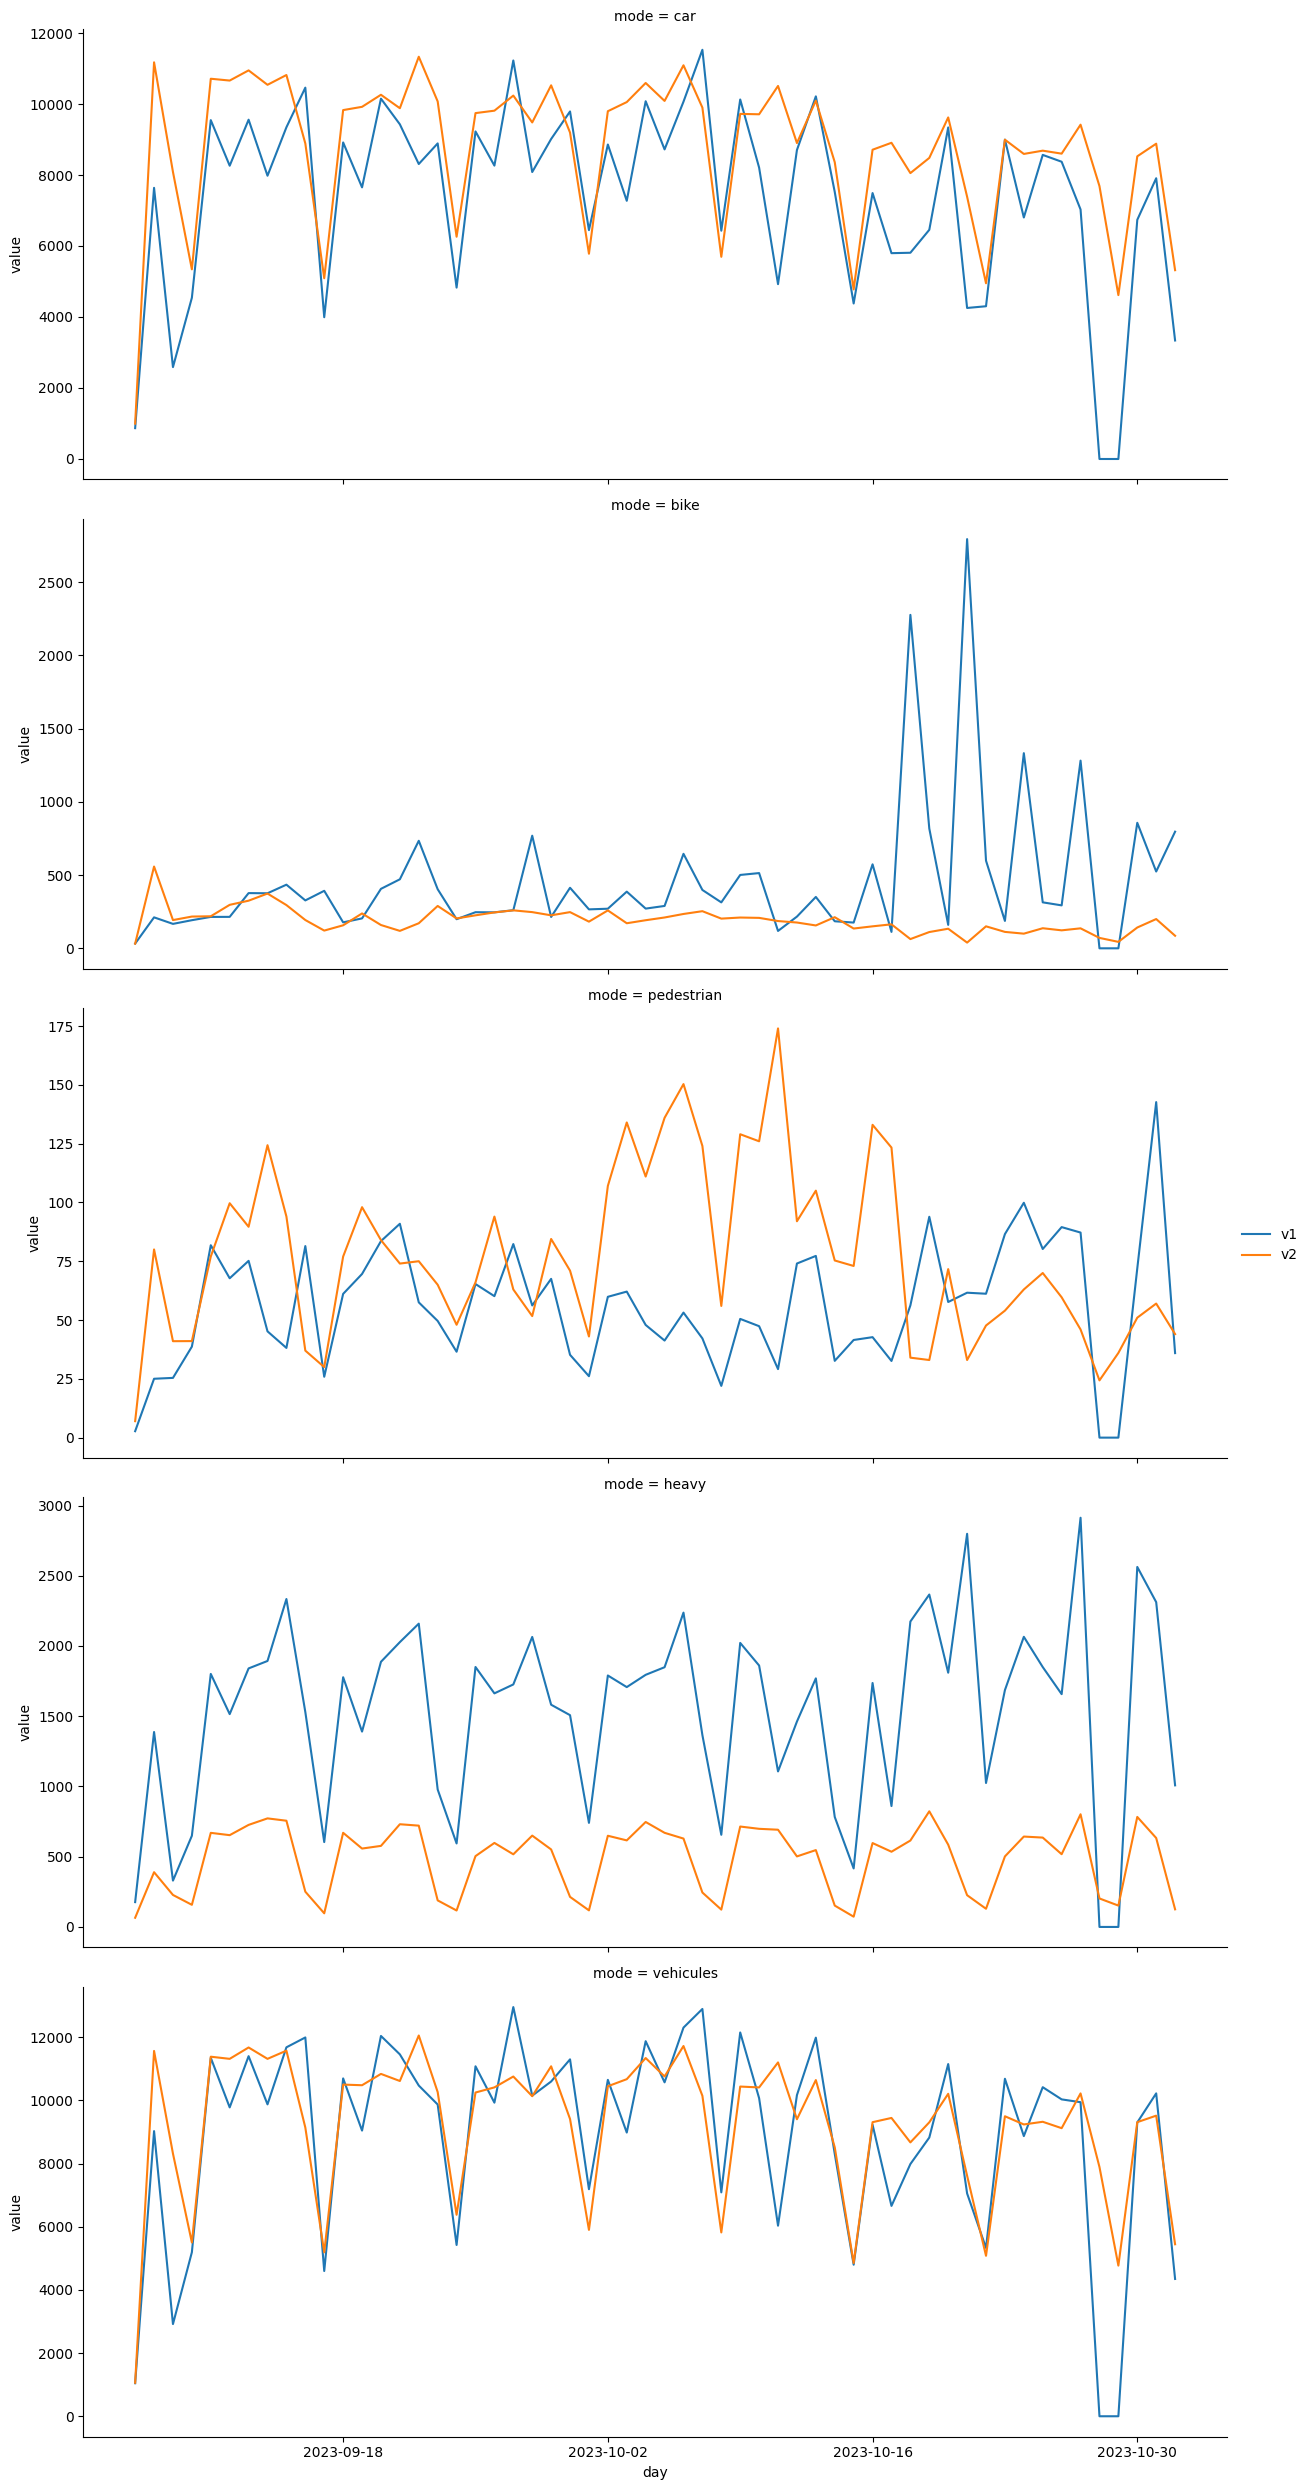

In [22]:
g = sns.FacetGrid(evolution, col="mode", sharey=False, col_wrap=1, height=5, aspect=2.5)
g.map_dataframe(sns.lineplot, x='day', y='value', hue='version', errorbar=None)
g.add_legend()
ax = plt.gca()
ax.xaxis.set_major_locator(bimensual_locator)

### Daily - by transportation mode and direction

In [24]:
evolution_direction = telraam_data_filtered.groupby(id_var, observed=False)[direction_modes].sum().reset_index()
evolution_direction = pd.melt(evolution_direction, id_vars=id_var, var_name="mode_direction")
evolution_direction[['mode', 'direction']] = evolution_direction['mode_direction'].str.split("_", expand = True)

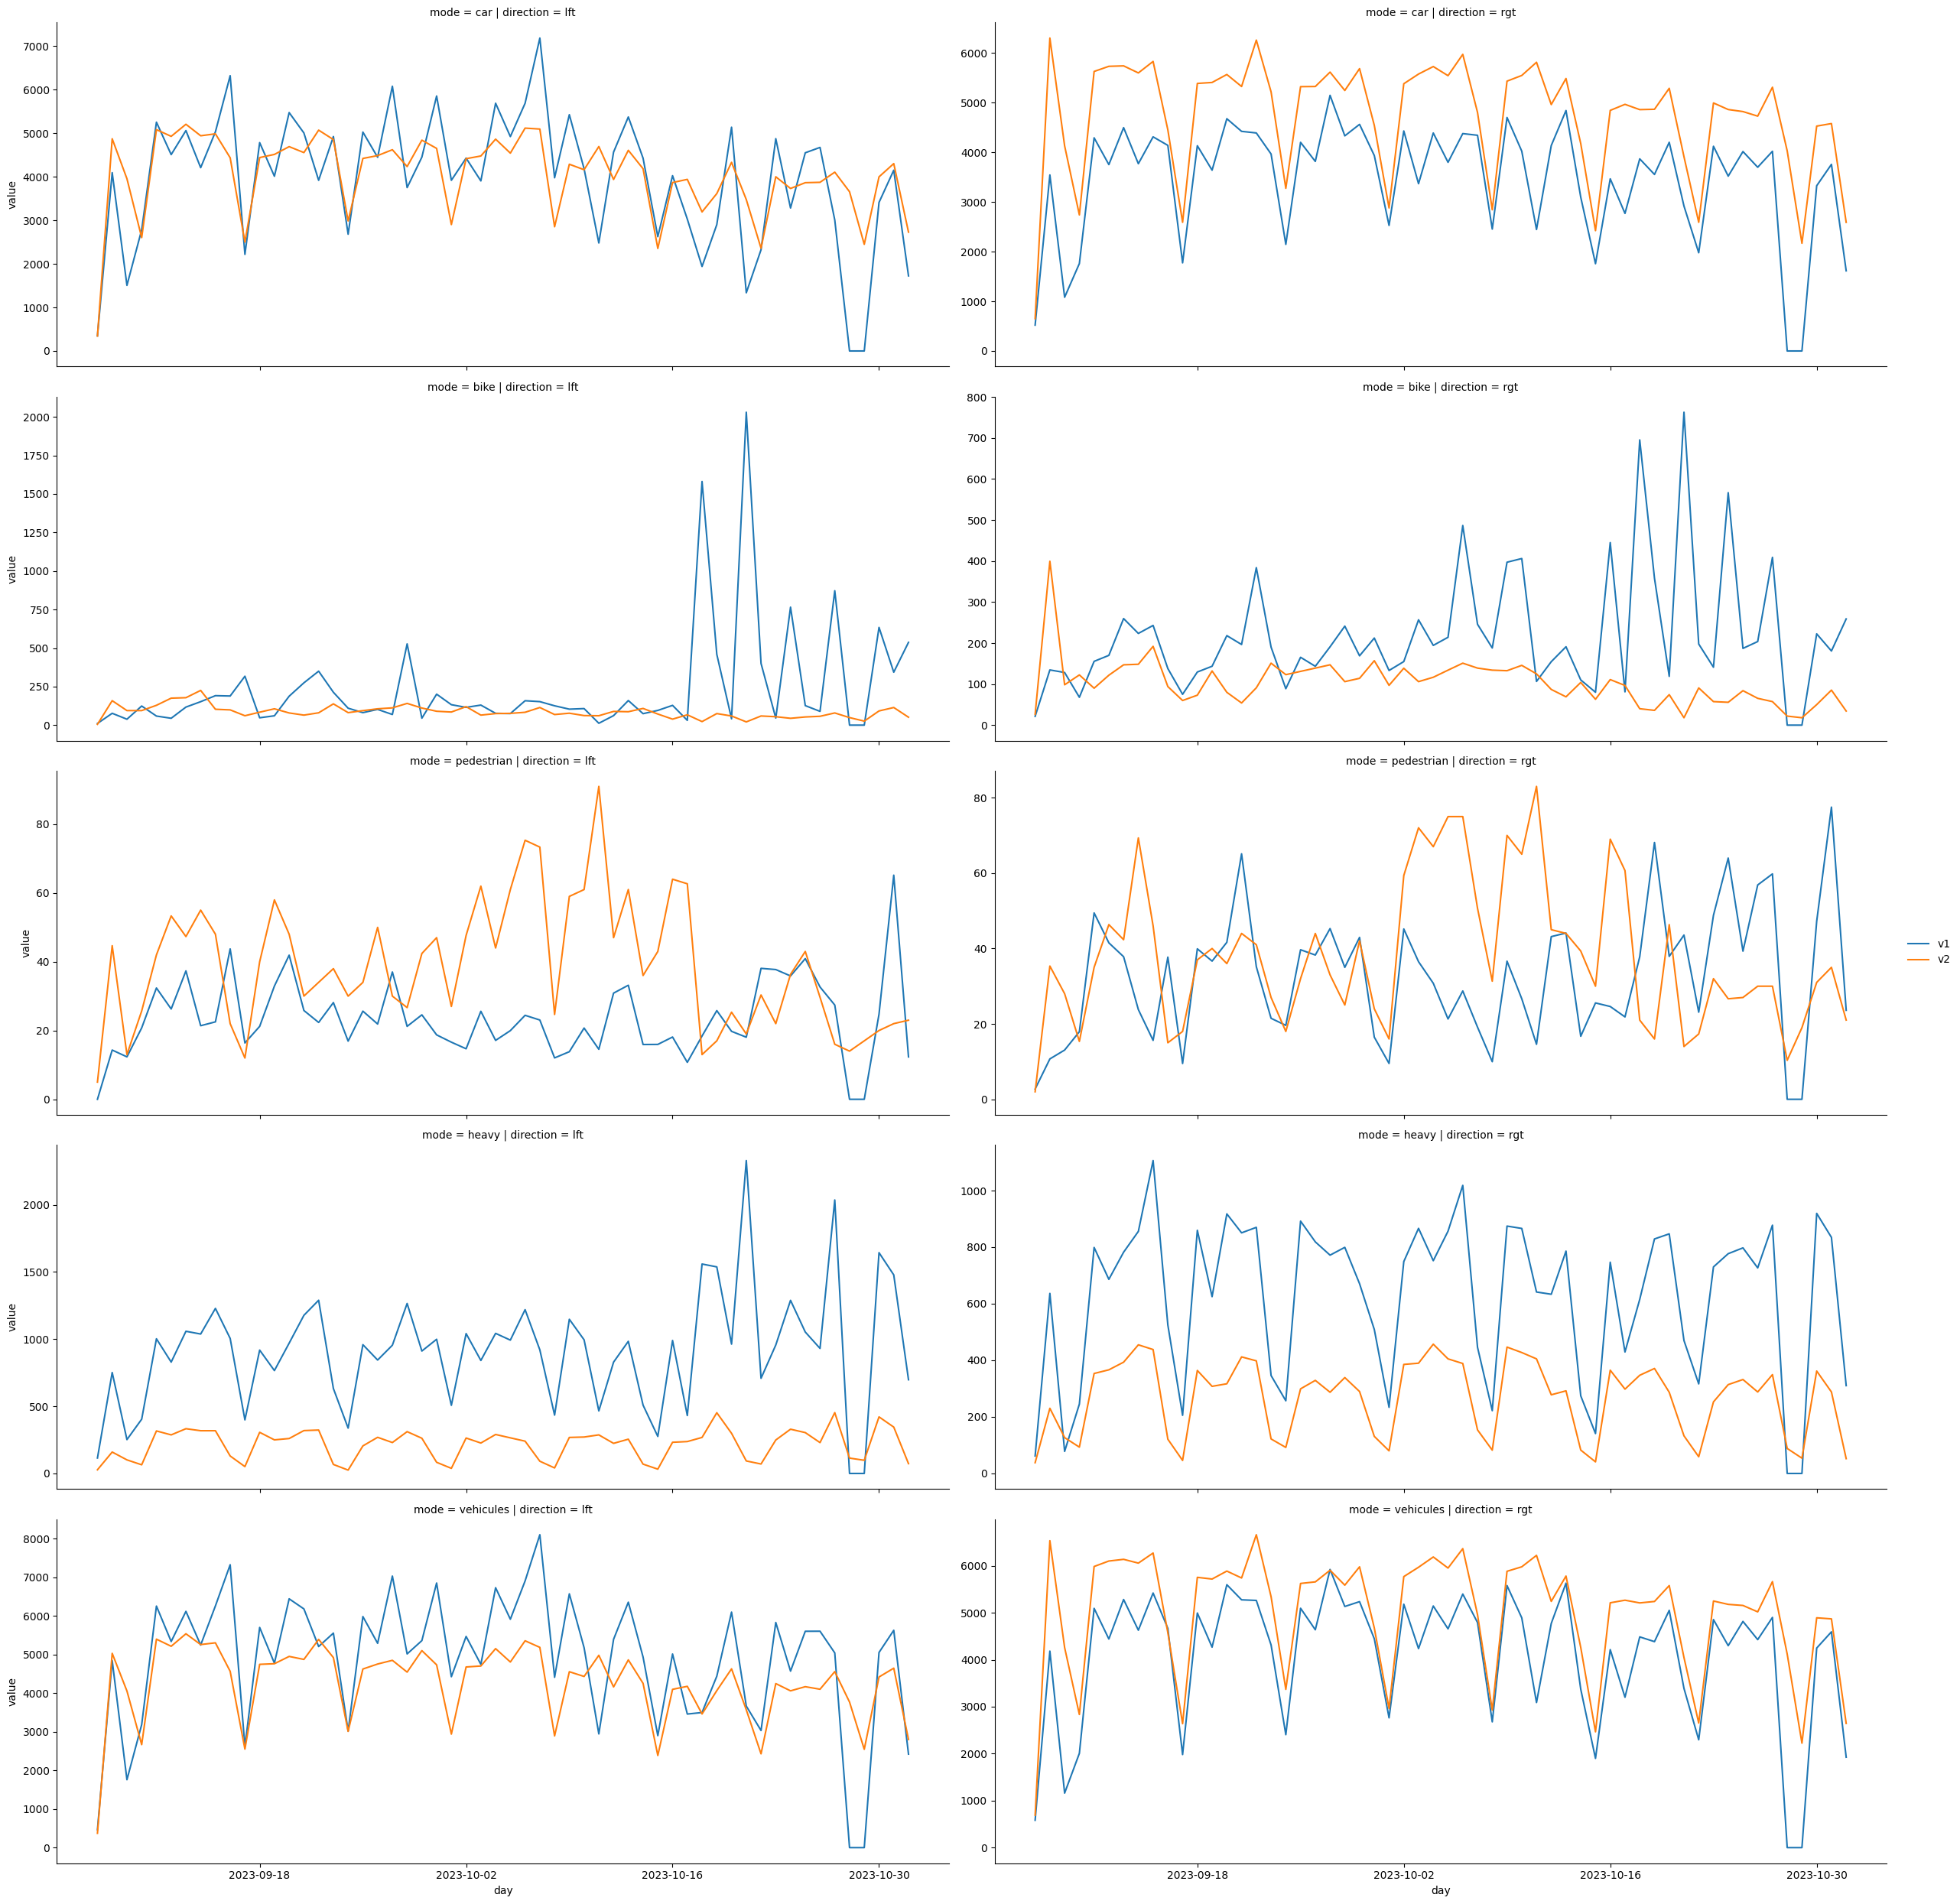

In [29]:
g = sns.FacetGrid(evolution_direction, col="direction", row="mode", sharey=False, height=5, aspect=2.5)
g.map_dataframe(sns.lineplot, x='day', y='value', hue='version', errorbar=None)
g.add_legend()
ax = plt.gca()
ax.xaxis.set_major_locator(bimensual_locator)